National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Applied Statistics

Peer Review Assignment: Credit Cards Defaults

Student: Andrei Batyrov (Fall2022)

Date: 29-Sep-2023

##### Table of Contents

1. [Description](#description)

2. [Assignment](#assignment)

    2.1. [Credit limit](#cred_lim)

    2.2. [Gender](#gender)

    2.3. [Education](#education)

    2.4. [Marital status](#marital_stat)

    2.5. [Age](#age)

3. [Discussion](#discussion)

---
##### <a id="description"></a>1. Description

The dataset for this assignment was collected in Taiwan in 2005, when the credit card issuers faced the cash and credit card debt crisis. In order to increase market share, card-issuing banks over-issued cash and credit cards to unqualified applicants. At the same time, most cardholders, irrespective of their repayment ability, overused credit card for consumption and accumulated heavy credit and cash–card debts. The crisis caused the blow to consumer finance confidence and was a big challenge for both banks and cardholders.

The data were collected from an important bank (a cash and credit card issuer) in Taiwan and the targets were credit card holders of the bank. Variables the dataset contains are:

- **LIMIT_BAL**: credit limit in NT dollars (including for client's family)
- **GENDER**: 1 = male; 2 = female
- **EDUCATION**: 0 = doctorate; 1 = masters; 2 = bachelor; 3 = school graduate; 4 = elementary education; 5 = other; 6 = no data.
- **MARITAL**: marital status: 0 = no answer; 1 = married; 2 = single; 3 = no data.
- **AGE**: age in years
- **PAY_APR -- PAY_SEP**: history of past monthly payments, from April (**PAY_APR**) to September (**PAY_SEP**) 2005. The measurement scale for the repayment status is 0 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- **BILL_APR -- BILL_SEP**: the amount of bill statement (NT dollars) each month
- **PAY_APR -- PAY_SEP**: the amount of previous payment (NT dollar)
- **default**: binary indicator of a default (1 = Yes; 0 = No)

We would like to explore whether there are differences between customers who defaulted and did not.

In [1]:
# Essential import
import numpy as np
import pandas as pd
from collections import namedtuple
from scipy.stats import norm, t, ttest_ind, mannwhitneyu, chi2, chi2_contingency, permutation_test
from scipy.stats.contingency import crosstab
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
np.random.seed(0)
alpha = 0.05
conf_lvl = 99.7 # in %; 3 sigma CI

---
##### <a id="assignment"></a>2. Assignment

In [2]:
# Load credit data
credit_data = pd.read_csv('credit_card_default_analysis.csv')
credit_data.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,BILL_SEP,BILL_AUG,BILL_JUL,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
credit_data.shape

(30000, 25)

In [4]:
# Check dtypes of columns of interest
cols_cat = ['GENDER', 'EDUCATION', 'MARITAL', 'default']
cols_num = ['LIMIT_BAL', 'AGE']
credit_data[cols_cat + cols_num].dtypes

GENDER       int64
EDUCATION    int64
MARITAL      int64
default      int64
LIMIT_BAL    int64
AGE          int64
dtype: object

In [5]:
# Check NaNs
credit_data[cols_cat + cols_num].isna().sum()

GENDER       0
EDUCATION    0
MARITAL      0
default      0
LIMIT_BAL    0
AGE          0
dtype: int64

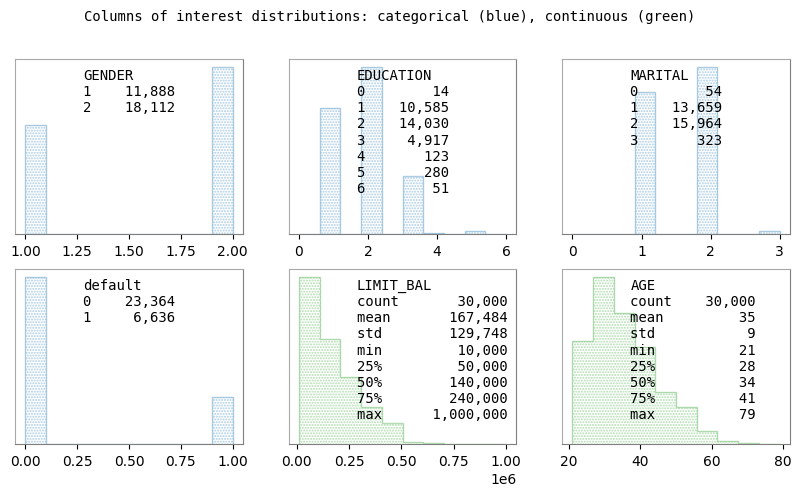

In [6]:
# Check distributions of columns of interest
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i, col in enumerate(cols_cat):
    ax = axs[i // 3][i % 3]
    ax.hist(credit_data[col], color='C0', alpha=0.35, histtype='step', hatch='.'*6)
    ax.text(0.3, 0.95, credit_data[col].value_counts().sort_index().apply('{:,.0f}'.format).to_string(), family='monospace', verticalalignment='top', transform=ax.transAxes)
    ax.set_yticks([])
for i, col in enumerate(cols_num):
    ax = axs[1][i + 1]
    ax.hist(credit_data[col], color='C2', alpha=0.35, histtype='step', hatch='.'*6)
    ax.text(0.3, 0.95, f"{col}\n{credit_data[col].describe().apply('{:,.0f}'.format).to_string()}", family='monospace', verticalalignment='top', transform=ax.transAxes)
    ax.set_yticks([])
for axis in fig.get_axes():
    spines = axis.spines
    spines['bottom'].set_color('C7')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('C7')
    spines['left'].set_color('darkgrey')
plt.suptitle('Columns of interest distributions: categorical (blue), continuous (green)', size=10, family='monospace');

In [7]:
# Everything looks good -- continue with statistical tests

##### <a id="cred_lim"></a>2.1. Credit limit: test whether there are differences between median credit limits of two groups

Distributions of credit limits in each group are plotted (as histograms, density estimates, or other appropriate distribution estimates) in a way that makes it easy to compare them.
- For the difference between two medians both point estimate and confidence interval are provided (with CI estimated with bootstrap)
- Appropriate statistical test is used, its assumptions are listed and examined, $p$-value is calculated
- Practical significance of the difference is discussed

Test setup:
- Number of samples: two independent (**default** = 1 | **default** = 0)
- Samples size: large ($\gg 30$)
- Question: difference between medians in groups
- Measurement scale: two continuous variables (**LIMIT_BAL** | **LIMIT_BAL**)
- Distribution normality / symmetry: both distributions have heavy right tails (asymmetric)
- Possible test: non-parametric bootstrap test for difference of an arbitrary statistic between two skewed continuous independent large samples
- Statistic: difference of medians
- Null distribution: no assumption; we will use obtained bootstrapped empirical distribution centered around zero by $\Delta med$ shift as the null

$X_1 = \{\text{Credit limit } | \text{ default} = 0\} \sim F_{X_1}$

$X_2 = \{\text{Credit limit } | \text{ default} = 1\} \sim F_{X_2}$

$H_0: \Delta med = med(X_1) - med(X_2) = 0$

$H_1: \Delta med = med(X_1) - med(X_2) \neq 0$ (two-sided)

$\alpha = 0.05 \text{ (95\% CI)}$

In [8]:
# Prepare samples
limit_bal_no_default = credit_data[credit_data['default'] == 0]['LIMIT_BAL']
limit_bal_default = credit_data[credit_data['default'] == 1]['LIMIT_BAL']

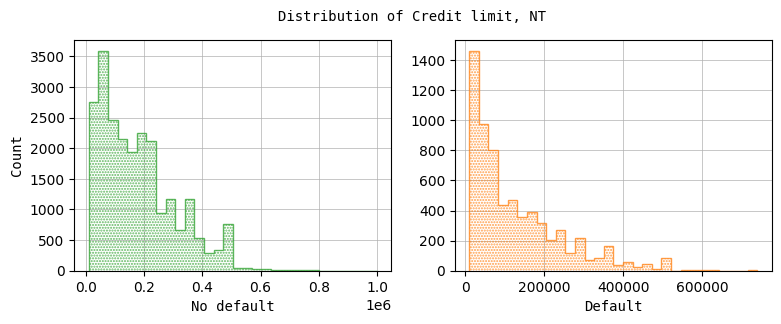

In [9]:
# Check distributions
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(limit_bal_no_default, bins=30, color = 'C2', alpha=0.75, histtype='step', hatch='.'*6)
plt.xlabel('No default', size=10, family='monospace')
plt.ylabel('Count', size=10, family='monospace')
plt.grid(lw=0.5)
plt.subplot(1, 2, 2)
plt.hist(limit_bal_default, bins=30, color = 'C1', alpha=0.75, histtype='step', hatch='.'*6)
plt.xlabel('Default', size=10, family='monospace')
plt.grid(lw=0.5)
plt.suptitle('Distribution of Credit limit, NT', size=10, family='monospace');

In [10]:
# Point estimate for difference of medians
print('No default group')
print(f'{"Median:":<20} {limit_bal_no_default.median():,.0f}')
print(f'{"":-<29}')
print('Default group')
print(f'{"Median:":<20} {limit_bal_default.median():,.0f}')
med_delta = limit_bal_no_default.median() - limit_bal_default.median()
print(f'{"":-<29}')
print(f'{"Expected difference:":<20} 0')
print(f'{"Observed difference:":<20} {med_delta:,.0f}')

No default group
Median:              150,000
-----------------------------
Default group
Median:              90,000
-----------------------------
Expected difference: 0
Observed difference: 60,000


In [11]:
# Bootstrap helper functions
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # Two-sided percentiles
    return boundaries

In [12]:
# Generate bootstrapped empirical distribution of difference of medians
limit_bal_no_default_med_scores = list(map(np.median, get_bootstrap_samples(limit_bal_no_default.values, 10000)))
limit_bal_default_med_scores = list(map(np.median, get_bootstrap_samples(limit_bal_default.values, 10000)))
med_delta_scores = np.array(list(map(lambda x: x[0] - x[1], zip(limit_bal_no_default_med_scores, limit_bal_default_med_scores))))

In [13]:
# 95% confidence interval estimate for difference of medians
ci = percentile_interval(med_delta_scores, alpha)
print(f'Two-sided alternative 95% confidence interval for difference of medians is [{ci[0]:,.0f}; {ci[1]:,.0f}]')

Two-sided alternative 95% confidence interval for difference of medians is [60,000; 70,000]


In [14]:
# Generate null distribution by shifting the obtained by bootstrapping empirical distribution by `med_delta` to center it around zero
# Source: Evgeniy Riabenko, Bootstrap tests, https://edu.hse.ru/mod/page/view.php?id=900083
null_distr = med_delta_scores - med_delta
# Null rejection boundaries
critical_boundaries = percentile_interval(null_distr, alpha)

In [15]:
# Find p_value by definition (two-sided) -- proportion of unusual values among all values under null in both tails
p_value = ((null_distr <= -med_delta) | (null_distr >= med_delta)).mean()
print(f'{p_value = :.1f}')
print(f'Difference of {med_delta:,.0f} in `no default` and `default` groups is statistically significant') \
if p_value < alpha else print(f'Difference of {med_delta:,.0f} is not statistically significant')

p_value = 0.0
Difference of 60,000 in `no default` and `default` groups is statistically significant


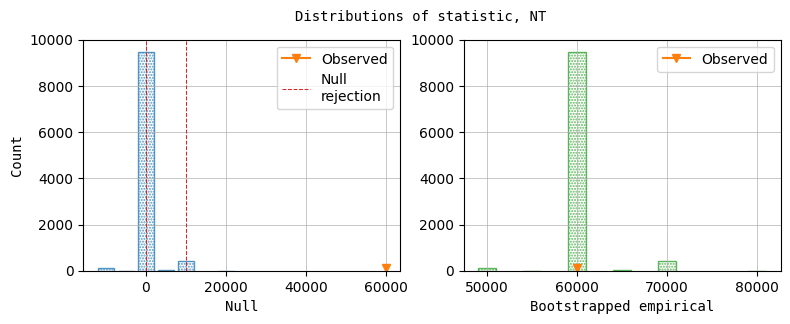

In [16]:
# Plot bootstrap test results
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
x = pd.Series(null_distr).value_counts().sort_index().index
y = pd.Series(null_distr).value_counts().sort_index().values
plt.bar(x, y, width=4000, align='center', color = 'white', edgecolor='C0', alpha=0.75, hatch='.'*6)
plt.plot(med_delta, 100, color='C1', markersize=6, marker='v', label='Observed')
plt.vlines(critical_boundaries, 0, plt.ylim()[1], color='C3', ls='--', lw=0.75, label='Null\nrejection')
plt.xlabel('Null', size=10, family='monospace')
plt.ylabel('Count', size=10, family='monospace')
plt.ylim([0, 10000])
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.subplot(1, 2, 2)
x = pd.Series(med_delta_scores).value_counts().sort_index().index
y = pd.Series(med_delta_scores).value_counts().sort_index().values
plt.bar(x, y, width=2000, align='center', color = 'white', edgecolor='C2', alpha=0.75, hatch='.'*6)
plt.plot(med_delta, 100, color='C1', markersize=6, marker='v', label='Observed')
plt.xlabel('Bootstrapped empirical', size=10, family='monospace')
plt.ylim([0, 10000])
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.suptitle('Distributions of statistic, NT', size=10, family='monospace');

Discussion

- Point estimate of difference between medians in two groups is 60,000.
- Two-sided alternative 95% confidence interval of difference is [60,000; 70,000].
- $P$-value is 0.0.
- We have shown that the difference of medians of credit limit in `no default` and `default` groups is statistically significant.
- It means that customers in `no default` group have _higher_ median credit limit than those in `default` group indeed.
- Note: we might also use non-parametric Mann-Whitney test to check if distributions in two groups are identical, and if so, then any arbitrary quantiles, including medians, should be equal. Visually, distributions look different, so most likely Mann-Whitney test would confirm the statistical significance of their difference, and thus difference of any quantile, including medians.

##### <a id="gender"></a>2.2. Gender: test whether gender composition of two groups differ

- Gender composition of each group is plotted in a way that makes it easy to compare them
- For the difference between two proportions both point estimate and confidence interval are provided
- Statistical test for independent proportions is used, its assumptions are listed and examined, $p$-value is calculated
- Practical significance of the difference is discussed

Test setup:
- Number of samples: two independent (**default** = 1 | **default** = 0)
- Samples size: large ($\gg 30$)
- Question: difference between proportions in groups
- Measurement scale: two binary variables (**GENDER** | **GENDER**)
- Distribution normality / symmetry: both distributions are asymmetric
- Possible test: $z$-test for difference between two proportions of two binary independent large samples
- Statistic: $z = \frac{p_{X_1} - p_{X_2}}{\sqrt{p(1-p)(\frac{1}{n_1} + \frac{1}{n_2})}}$
- Null distribution: $\mathcal N(0, 1)$

$X_1 = \{\text{Gender } | \text{ default} = 0\} \sim Ber(p_{X_1})$

$X_2 = \{\text{Gender } | \text{ default} = 1\} \sim Ber(p_{X_2})$

$n_i = |X_i|$, $k_i = |X_i \setminus \{2\}|$ (men) or $k_i = |X_i \setminus \{1\}|$ (women), at researcher's discretion, since both proportions will add up to 1.0, $p_{X_i} = \frac{k_i}{n_i}$, $p = \frac{k_1 + k_2}{n_1 + n_2}$

$H_0: p_{X_1} = p_{X_2}$

$H_1: p_{X_1} \neq p_{X_2}$ (two-sided)

$\alpha = 0.05 \text{ (95\% CI)}$

In [17]:
# Prepare samples
gender_no_default = credit_data[credit_data['default'] == 0]['GENDER']
gender_default = credit_data[credit_data['default'] == 1]['GENDER']

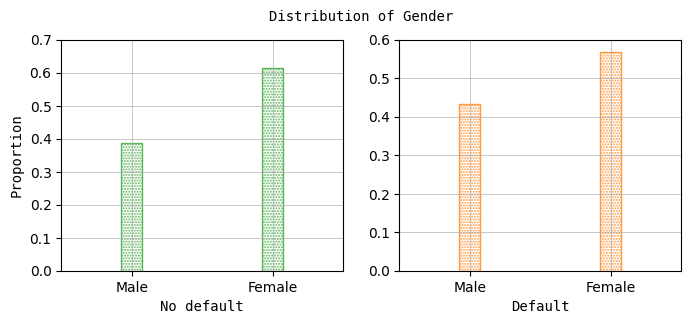

In [18]:
# Check distributions
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
counts = gender_no_default.value_counts(normalize=True).sort_index()
plt.bar([1, 2], counts, width=0.15, align='center', color = 'white', edgecolor='C2', alpha=0.75, hatch='.'*6)
plt.xlabel('No default', size=10, family='monospace')
plt.ylabel('Proportion', size=10, family='monospace')
plt.xticks([1, 2], ['Male', 'Female'])
plt.xlim([0.5, 2.5])
plt.ylim([0.0, 0.7])
plt.grid(lw=0.5)
plt.subplot(1, 2, 2)
counts = gender_default.value_counts(normalize=True).sort_index()
plt.bar([1, 2], counts, width=0.15, align='center', color = 'white', edgecolor='C1', alpha=0.75, hatch='.'*6)
plt.xlabel('Default', size=10, family='monospace')
plt.xticks([1, 2], ['Male', 'Female'])
plt.xlim([0.5, 2.5])
plt.ylim([0.0, 0.6])
plt.grid(lw=0.5)
plt.suptitle('Distribution of Gender', size=10, family='monospace');

In [19]:
# Point estimate for difference between two proportions
# Let's work with ladies :-)
women_no_default_count = gender_no_default.value_counts()[2]
women_no_default_prop = (gender_no_default == 2).mean()
women_default_count = gender_default.value_counts()[2]
women_default_prop = (gender_default == 2).mean()
print('No default group')
print(f'{"Women count:":<20} {women_no_default_count:,.0f} / {gender_no_default.shape[0]:,.0f}')
print(f'{"Women proportion:":<20} {women_no_default_prop:.5f}')
print(f'{"":-<37}')
print('Default group')
print(f'{"Women count:":<20} {women_default_count:,.0f} / {gender_default.shape[0]:,.0f}')
print(f'{"Women proportion:":<20} {women_default_prop:.5f}')
print(f'{"":-<37}')
prop_delta = women_no_default_prop - women_default_prop
print(f'{"Expected difference:":<20} 0.0')
print(f'{"Observed difference:":<20} {prop_delta:.5f} ({prop_delta:.2%})')

No default group
Women count:         14,349 / 23,364
Women proportion:    0.61415
-------------------------------------
Default group
Women count:         3,763 / 6,636
Women proportion:    0.56706
-------------------------------------
Expected difference: 0.0
Observed difference: 0.04709 (4.71%)


In [20]:
# Null distribution -- standard normal distribution
null_distr = norm(loc=0, scale=1)
# Null rejection boundaries
critical_boundaries = null_distr.ppf([alpha / 2, 1 - alpha / 2])
# z-score and p-value
prop = (women_no_default_count + women_default_count) / (gender_no_default.shape[0] + gender_default.shape[0])
se = np.sqrt(prop * (1 - prop) * (1 / gender_no_default.shape[0] + 1 / gender_default.shape[0]))
z_score = prop_delta / se
p_value = 2 * null_distr.cdf(-np.abs(z_score)) # two-sided
# 95% confidence interval estimate for difference between two proportions
ci = [prop_delta - critical_boundaries[1] * se, prop_delta + critical_boundaries[1] * se]
print(f'Two-sided alternative 95% confidence interval for difference between two proportions is [{ci[0]:,.5f}; {ci[1]:,.5f}]')
print(f'{p_value = :.2e}')
print(f'Difference between proportions of women in `no default` and `default` groups is statistically significant') \
if p_value < alpha else print(f'Difference between women in `no default` and `default` groups is not statistically significant')

Two-sided alternative 95% confidence interval for difference between two proportions is [0.03376; 0.06043]
p_value = 4.47e-12
Difference between proportions of women in `no default` and `default` groups is statistically significant


In [21]:
# Same result can be obtained with `statsmodels.stats.proportion.proportions_ztest()` function
proportions_ztest(count=np.array([women_no_default_count, women_default_count]), \
                    nobs=np.array([gender_no_default.shape[0], gender_default.shape[0]]), \
                    alternative='two-sided')

(6.921375088562897, 4.472804335814113e-12)

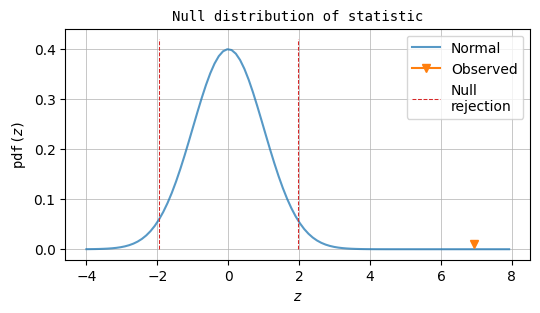

In [22]:
# Plot z-test results
plt.figure(figsize=(6, 3))
x = np.linspace(-4, z_score + 1, 100)
plt.plot(x, null_distr.pdf(x), color = 'C0', alpha=0.75, label='Normal')
plt.plot(z_score, 0.01, color='C1', markersize=6, marker='v', label='Observed')
plt.vlines(critical_boundaries, 0, plt.ylim()[1], color='C3', ls='--', lw=0.75, label='Null\nrejection')
plt.xlabel('$z$', size=10, family='monospace')
plt.ylabel('pdf($z$)', size=10, family='monospace')
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.title('Null distribution of statistic', size=10, family='monospace');

Discussion

- Point estimate of difference between proportions (of women, in this case) in two groups is 0.04709.
- Two-sided alternative 95% confidence interval of difference is [0.03376; 0.06043].
- $P$-value is $4.47 \times 10^{-12}$.
- We have shown that the difference between proportions of women in `no default` and `default` groups is statistically significant.
- It means that proportion of women in `no default` group is _higher_ than those in `default` group indeed. Since proportions add up to 1.0, this result also applies to men: proportion of men in `no default` group is _lower_ than those in `default` group indeed.

##### <a id="education"></a>2.3. Education: test whether education levels differ between two groups. If it does, then how exactly?

- Levels of education in each group are visualized in a way that makes it easy to compare them
- Chi-squared test assumptions are checked
- $P$-value is calculated
- Followup: differences between groups are analyzed with standardized Pearson residuals

Test setup:
- Number of samples: two paired (**EDUCATION** | **default**)
- Samples size: large ($\gg 30$)
- Question: difference between education levels in groups
- Measurement scale: two categorical variables (**EDUCATION** | **default**)
- Distribution normality / symmetry: both distributions are asymmetric
- Possible test: permutation test for independence of two categorical large samples
- Statistic: $\chi^2 = \sum_{i=1}^{k_1} \sum_{j=1}^{k_2} \frac{(n_{ij} - e_{ij})^2}{e_{ij}}$
- Null distribution: no assumption; generated empirically by permutation test; we will also compare it with $\chi^2$-distribution

$X_1 = \{\text{Education}\} \sim F_{X_1}$

$X_2 = \{\text{default}\} \sim F_{X_2}$

In the contingency table: $k_1$ is the number of rows, $k_2$ is the number of columns, $n_{i+}$ is the total of observed counts in the $i$-th row, $n_{+j}$ is the total of observed counts in the $j$-th column, $n$ is the total across all observed counts

$H_0: e_{ij} = \frac{n_{i+} n_{+j}}{n}$

$H_1: e_{ij} \neq \frac{n_{i+} n_{+j}}{n}$ (two-sided)

$\alpha = 0.05 \text{ (95\% CI)}$

In [23]:
# Prepare contingency table of observed counts
# Rows are `education` levels
# Cols are `no default` and `default`
default_status = ['No default', 'Default']
education_level = ['PhD', 'Masters', 'Bachelor', 'School grad', 'Elementary', 'Other', 'No data']
df_columns = pd.MultiIndex.from_product([default_status], names=['Default Status'])
df_index = pd.MultiIndex.from_product([education_level], names=['Education Level'])
observed_df = pd.DataFrame(crosstab(credit_data['EDUCATION'], credit_data['default']).count)
observed_df.columns = df_columns
observed_df.index = df_index

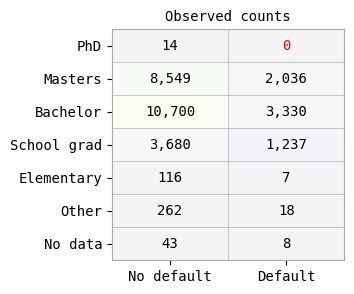

In [24]:
# Check observed distribution
plt.figure(figsize=(3, 3))
plt.imshow(observed_df.values, cmap='viridis', alpha=0.05)
plt.title('Observed counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(observed_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), default_status, size=10, family='monospace')
plt.yticks(np.arange(7), education_level, size=10, family='monospace')
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(7) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
for axis in plt.gcf().get_axes():
    spines = axis.spines
    spines['bottom'].set_color('darkgrey')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('darkgrey')
    spines['left'].set_color('darkgrey')

Note: 13/14 (> 80%) of cells have count more than 5. However, to apply $\chi^2$-test, it is required not to have zero counts. It is seen, that `PhD` did not default in a single case. So, strictly speaking, we should not use $\chi^2$-test for this contingency table. Even though, there are only $14$ `PhD` customers, which is merely 14/30000 $\approx$ 0.05% of all customers, we will use permutation test for $\chi^2$-statistic (instead of $\chi^2$-test).

In [25]:
# Chi2 test function
def chi2test(observed_ct=None, sample1=None, sample2=None, alternative='two-sided'):
    '''
    observed_ct: Two-variable contingency table with observed joint distribution,
                 if absent, it will be constructed from `sample1` and `sample2`
    E: Two-variable contingency table with expected joint distribution under H_0
    R: Standardized Pearson residuals; they have N(0, 1) asymptotic distribution
    H_0: Variables are independent, i.e. chi2_score = 0
    H_1: Variables are not independent, i.e. chi2_score != 0
    '''
    
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("'alternative' must be 'two-sided', 'less' or 'greater'")
    
    if observed_ct is None:
        observed_ct = crosstab(sample1, sample2).count

    K_i, K_j = observed_ct.shape
    n = observed_ct.sum()
    n_i_plus = observed_ct.sum(axis=1)
    n_plus_j = observed_ct.sum(axis=0)

    E = []
    for i in range(K_i):
        col = []
        for j in range(K_j):
            e = n_i_plus[i] * n_plus_j[j] / n
            col.append(e)
        E.append(col)
    E = np.array(E)

    chi2_score = ((observed_ct - E) ** 2 / E).sum()
    
    df = (K_i - 1) * (K_j - 1) # degrees of freedom
    
    chi2_rv = chi2(df=df)
    if alternative == 'two-sided':
        #p_value = 2 * chi2_rv.cdf(-np.abs(chi2_score)) # Should not use this, since chi2 is asymmetric
        p_value = chi2_rv.cdf(-chi2_score) + 1.0 - chi2_rv.cdf(chi2_score) # Use this instead
    elif alternative == 'greater':
        p_value = 1.0 - chi2_rv.cdf(chi2_score)
    else: # alternative == 'less'
        p_value = chi2_rv.cdf(chi2_score)

    R = []
    for i in range(K_i):
        col = []
        for j in range(K_j):
            r = (observed_ct[i, j] - E[i, j]) / np.sqrt(E[i, j] * (1 - n_i_plus[i] / n) * (1 - n_plus_j[j] / n))
            col.append(r)
        R.append(col)
    R = np.array(R)

    result = namedtuple('Chi2test',  ['statistic', 'pvalue', 'df', 'expected_table', 'residuals'])(chi2_score, p_value, df, E, R)
    return result

In [26]:
# chi2-score and p-value
# Here we use permutation test for chi2-statistic to obtain null distribution and p-value
result_permut = permutation_test((credit_data['EDUCATION'].values, credit_data['default'].values), \
                           statistic=lambda x, y: chi2test(sample1=x, sample2=y).statistic, \
                            alternative='two-sided', \
                            permutation_type='pairings', \
                            n_resamples=5000)
chi2_score = result_permut.statistic
print(f'{chi2_score = :.2f}')
p_value = result_permut.pvalue
print(f'{p_value = :.1e}')
print(f'Education levels and default status are not independent') \
if p_value < alpha else print(f'Education levels and default status are independent')

chi2_score = 163.22
p_value = 4.0e-04
Education levels and default status are not independent


In [27]:
# Expected counts
result_chi2 = chi2test(observed_ct=observed_df.values, alternative='two-sided')
df = result_chi2.df
expected_df = pd.DataFrame(result_chi2.expected_table)
expected_df.columns = df_columns
expected_df.index = df_index

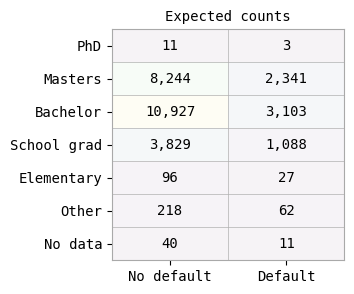

In [28]:
# Check expected distribution
plt.figure(figsize=(3, 3))
plt.imshow(expected_df.values, cmap='viridis', alpha=0.05)
plt.title('Expected counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(expected_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), default_status, size=10, family='monospace')
plt.yticks(np.arange(7), education_level, size=10, family='monospace')
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(7) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
for axis in plt.gcf().get_axes():
    spines = axis.spines
    spines['bottom'].set_color('darkgrey')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('darkgrey')
    spines['left'].set_color('darkgrey')

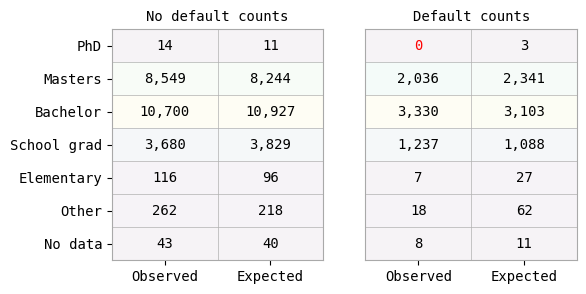

In [29]:
# Let's look at the observed and expected counts side by side
diff_no_default_df = pd.concat([observed_df['No default'], expected_df['No default']], axis=1)
diff_no_default_df.columns = ['Observed', 'Expected']
diff_default_df = pd.concat([observed_df['Default'], expected_df['Default']], axis=1)
diff_default_df.columns = ['Observed', 'Expected']

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(diff_no_default_df.values, cmap='viridis', alpha=0.05)
plt.title('No default counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(diff_no_default_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), ['Observed', 'Expected'], size=10, family='monospace')
plt.yticks(np.arange(7), education_level, size=10, family='monospace')
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(7) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
plt.subplot(1, 2, 2)
plt.imshow(diff_default_df.values, cmap='viridis', alpha=0.05)
plt.title('Default counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(diff_default_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), ['Observed', 'Expected'], size=10, family='monospace')
plt.yticks([])
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(7) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
for axis in plt.gcf().get_axes():
    spines = axis.spines
    spines['bottom'].set_color('darkgrey')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('darkgrey')
    spines['left'].set_color('darkgrey')

In [30]:
# Theoretical null distribution -- chi2 distribution with `df` degrees of freedom
null_distr_theory = chi2(df=df)
# Generated null distribution
null_distr_permut = result_permut.null_distribution
# Null rejection boundaries
critical_boundaries = percentile_interval(null_distr_permut, alpha)

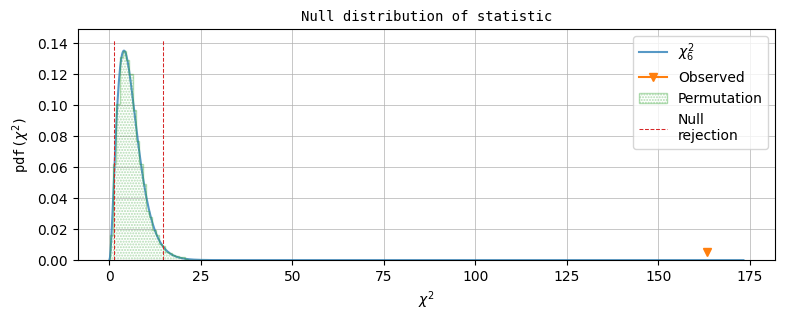

In [31]:
# Plot permutation test results
plt.figure(figsize=(9, 3))
x = np.linspace(0, chi2_score + 10, 1000)
plt.plot(x, null_distr_theory.pdf(x), color = 'C0', alpha=0.75, label=f'$\chi^2_{{{df:.0f}}}$')
plt.plot(chi2_score, 0.005, color='C1', markersize=6, marker='v', label='Observed')
plt.hist(null_distr_permut, bins=30, density=True, color = 'C2', alpha=0.35, histtype='step', hatch='.'*6, label='Permutation')
plt.vlines(critical_boundaries, 0, plt.ylim()[1], color='C3', ls='--', lw=0.75, label='Null\nrejection')
plt.xlabel('$\chi^2$', size=10, family='monospace')
plt.ylabel('pdf($\chi^2$)', size=10, family='monospace')
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.title(f'Null distribution of statistic', size=10, family='monospace');

Follow-up: examine standardized Pearson residuals. They have approximately standard normal distribution. Let's define outliers as being outside of $3 \sigma$ CI

In [32]:
z = norm().ppf((1 + conf_lvl / 100) / 2)
residuals_df = pd.DataFrame(result_chi2.residuals)
residuals_df.columns = df_columns
residuals_df.index = df_index
residuals_df.style\
    .highlight_between(right=-z, color='lightgreen')\
    .highlight_between(left=z, color='lightgreen')\
    .set_caption('<h4>Standardized Pearson Residuals: |green| > 3</h4>')

Default Status,"('No default',)","('Default',)"
Education Level,,
PhD,1.994550,-1.994550
Masters,8.890227,-8.890227
Bachelor,-6.316328,6.316328
School grad,-5.612397,5.612397
Elementary,4.398948,-4.398948
Other,6.355829,-6.355829
No data,1.107928,-1.107928


Discussion

- We have calculated the obtained and expected count for each level of education and default status.
- $P$-value under the null hypothesis of independence of education and default variables is $4.0 \times 10^{-4}$.
- We have shown that education and default variables are _not_ independent and their dependency is statistically significant.
- Defaulting _less_ than expected (good): `PhD`, `Masters`, `Elementary`, `Other`, `No data`.
- Defaulting _more_ than expected (bad): `Bachelor`, `School grad`.
- Default status is strongly dependent on almost all levels of education, as seen by standardized Pearson residuals: only `PhD` and `No data` customers are within the $3 \sigma$ confidence interval, while the rest education customers are well beyond $3 \sigma$.

##### <a id="marital_stat"></a>2.4. Marital Status: Check how marital status is related to the default indicator: you need to propose a measure by which you can measure the possible relationship of these variables and calculate its value

- Marital statuses in each group are visualized in a way that makes it easy to compare them
- Chi-squared test assumptions are checked
- $P$-value is calculated with permutation test for independence of categorical variables
- Followup: differences between groups are analyzed with standardized Pearson residuals

Test setup:
- Number of samples: two paired (**MARITAL** | **default**)
- Samples size: large ($\gg 30$)
- Question: relation between marital status and default indicator
- Measurement scale: two categorical variables (**MARITAL** | **default**)
- Distribution normality / symmetry: both distributions are asymmetric
- Possible test: $\chi^2$-test for independence of two categorical large samples
- Statistic: $\chi^2 = \sum_{i=1}^{k_1} \sum_{j=1}^{k_2} \frac{(n_{ij} - e_{ij})^2}{e_{ij}}$
- Null distribution: $\chi^2_{(k_1 - 1)(k_2 - 1)}$

$X_1 = \{\text{Marital}\} \sim F_{X_1}$

$X_2 = \{\text{default}\} \sim F_{X_2}$

In the contingency table: $k_1$ is the number of rows, $k_2$ is the number of columns, $n_{i+}$ is the total of observed counts in the $i$-th row, $n_{+j}$ is the total of observed counts in the $j$-th column, $n$ is the total across all observed counts

$H_0: e_{ij} = \frac{n_{i+} n_{+j}}{n}$

$H_1: e_{ij} \neq \frac{n_{i+} n_{+j}}{n}$ (two-sided)

$\alpha = 0.05 \text{ (95\% CI)}$

In [33]:
# Prepare contingency table of observed counts
# Rows are `marital` status
# Cols are `no default` and `default`
default_status = ['No default', 'Default']
marital_status = ['No answer', 'Married', 'Single', 'No data']
df_columns = pd.MultiIndex.from_product([default_status], names=['Default Status'])
df_index = pd.MultiIndex.from_product([marital_status], names=['Marital Status'])
observed_df = pd.DataFrame(crosstab(credit_data['MARITAL'], credit_data['default']).count)
observed_df.columns = df_columns
observed_df.index = df_index

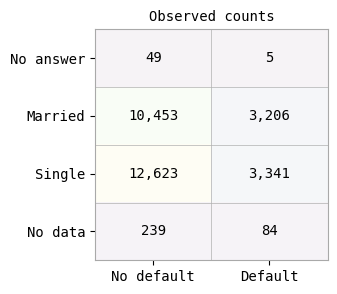

In [34]:
# Check observed distribution
plt.figure(figsize=(3, 3))
plt.imshow(observed_df.values, cmap='viridis', alpha=0.05)
plt.title('Observed counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(observed_df.values):
    plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), default_status, size=10, family='monospace')
plt.yticks(np.arange(4), marital_status, size=10, family='monospace')
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(4) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
for axis in plt.gcf().get_axes():
    spines = axis.spines
    spines['bottom'].set_color('darkgrey')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('darkgrey')
    spines['left'].set_color('darkgrey')

Note: 7/8 (> 80%) of cells have count more than 5, and no zero counts -- can proceed with $\chi^2$-test. Also, since $\chi^2$-test is applicable here, we don't need permutation test to calculate $p$-value -- it will be calculated with $\chi^2$-test.

In [35]:
# chi2-score and p-value
result = chi2test(observed_df.values, alternative='two-sided')
chi2_score = result.statistic
p_value = result.pvalue
df = result.df
print(f'{chi2_score = :.2f}')
print(f'{p_value = :.4e}')
print(f'Marital status and default status are not independent') \
if p_value < alpha else print(f'Marital status and default status are independent')

chi2_score = 35.66
p_value = 8.8259e-08
Marital status and default status are not independent


In [36]:
# Expected counts
expected_df = pd.DataFrame(result.expected_table)
expected_df.columns = df_columns
expected_df.index = df_index

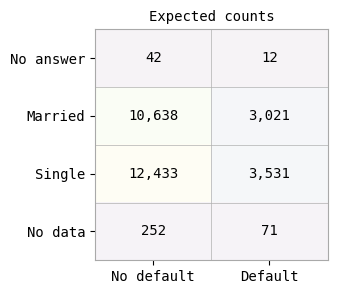

In [37]:
# Check expected distribution
plt.figure(figsize=(3, 3))
plt.imshow(expected_df.values, cmap='viridis', alpha=0.05)
plt.title('Expected counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(expected_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), default_status, size=10, family='monospace')
plt.yticks(np.arange(4), marital_status, size=10, family='monospace')
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(4) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
for axis in plt.gcf().get_axes():
    spines = axis.spines
    spines['bottom'].set_color('darkgrey')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('darkgrey')
    spines['left'].set_color('darkgrey')

In [38]:
# Same result can be obtained with `scipy.stats.chi2_contingency()` function
print(chi2_contingency(observed_df.values))

Chi2ContingencyResult(statistic=35.66239583433609, pvalue=8.825862457577375e-08, dof=3, expected_freq=array([[4.20552000e+01, 1.19448000e+01],
       [1.06376292e+04, 3.02137080e+03],
       [1.24327632e+04, 3.53123680e+03],
       [2.51552400e+02, 7.14476000e+01]]))


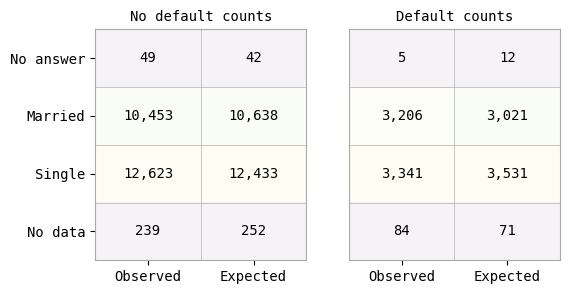

In [39]:
# Let's look at the observed and expected counts side by side
diff_no_default_df = pd.concat([observed_df['No default'], expected_df['No default']], axis=1)
diff_no_default_df.columns = ['Observed', 'Expected']
diff_default_df = pd.concat([observed_df['Default'], expected_df['Default']], axis=1)
diff_default_df.columns = ['Observed', 'Expected']

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(diff_no_default_df.values, cmap='viridis', alpha=0.05)
plt.title('No default counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(diff_no_default_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), ['Observed', 'Expected'], size=10, family='monospace')
plt.yticks(np.arange(4), marital_status, size=10, family='monospace')
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(4) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
plt.subplot(1, 2, 2)
plt.imshow(diff_default_df.values, cmap='viridis', alpha=0.05)
plt.title('Default counts', size=10, family='monospace')
for (j, i), label in np.ndenumerate(diff_default_df.values):
    if label:
        plt.text(i, j, f'{label:,.0f}', ha='center', va='center', size=10, family='monospace')
    else:
        plt.text(i, j, f'{label:,.0f}', color='red', ha='center', va='center', size=10, family='monospace')
plt.gca().set_aspect('auto')
plt.xticks(np.arange(2), ['Observed', 'Expected'], size=10, family='monospace')
plt.yticks([])
plt.xticks(np.arange(2) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(4) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5)
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
for axis in plt.gcf().get_axes():
    spines = axis.spines
    spines['bottom'].set_color('darkgrey')
    spines['top'].set_color('darkgrey')
    spines['right'].set_color('darkgrey')
    spines['left'].set_color('darkgrey')

In [40]:
# Null distribution -- chi2 distribution with `df` degrees of freedom
null_distr = chi2(df=df)
# Null rejection boundaries
critical_boundaries = null_distr.ppf([alpha / 2, 1 - alpha / 2])

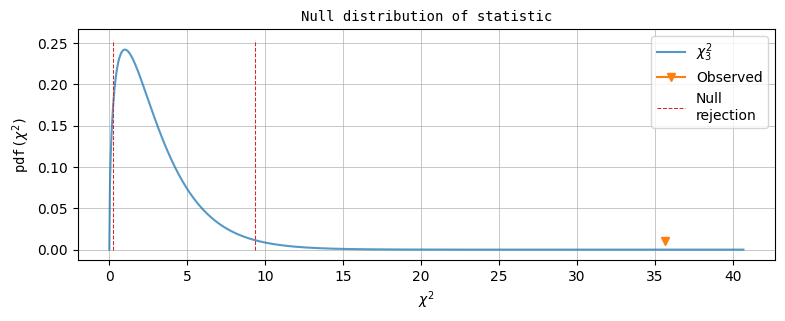

In [41]:
# Plot chi2-test results
plt.figure(figsize=(9, 3))
x = np.linspace(0, chi2_score + 5, 1000)
plt.plot(x, null_distr.pdf(x), color = 'C0', alpha=0.75, label=f'$\chi^2_{{{df:.0f}}}$')
plt.plot(chi2_score, 0.01, color='C1', markersize=6, marker='v', label='Observed')
plt.vlines(critical_boundaries, 0, plt.ylim()[1], color='C3', ls='--', lw=0.75, label='Null\nrejection')
plt.xlabel('$\chi^2$', size=10, family='monospace')
plt.ylabel('pdf($\chi^2$)', size=10, family='monospace')
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.title(f'Null distribution of statistic', size=10, family='monospace');

Follow-up: examine standardized Pearson residuals. They have approximately standard normal distribution. Let's define outliers as being outside of $3 \sigma$ CI

In [42]:
z = norm().ppf((1 + conf_lvl / 100) / 2)
residuals_df = pd.DataFrame(result.residuals)
residuals_df.columns = df_columns
residuals_df.index = df_index
residuals_df.style\
    .highlight_between(right=-z, color='lightgreen')\
    .highlight_between(left=z, color='lightgreen')\
    .set_caption('<h4>Standardized Pearson Residuals: |green| > 3</h4>')

Default Status,"('No default',)","('Default',)"
Marital Status,,
No answer,2.279022,-2.279022
Married,-5.157114,5.157114
Single,5.303433,-5.303433
No data,-1.691884,1.691884


Discussion

- We have calculated the obtained and expected count for each marital status and default status.
- $P$-value under the null hypothesis of independence of marital status and default variables is $8.83 \times 10^{-8}$.
- We have shown that marital status and default variables are _not_ independent and their dependency is statistically significant.
- Defaulting _less_ than expected (good): `No answer`, `Single`.
- Defaulting _more_ than expected (bad): `Married`, `No data`.
- Default status is strongly dependent on `Single` and `Married` statuses, as seen by standardized Pearson residuals: they are well beyond $3 \sigma$.

##### <a id="age"></a>2.5. Age: test whether there are differences between mean ages of clients in two groups

- Age distributions in each group are plotted (as histograms, density estimates, or other appropriate distribution estimates) in a way that makes it easy to compare them
- For the difference between two means both point estimate and confidence interval are provided (with CI estimated with Student distribution-based method or bootstrap)
- Appropriate statistical test is used, its assumptions are listed and examined, $p$-value is calculated
- Practical significance of the difference is discussed

Test setup:
- Number of samples: two independent (**default** = 1 | **default** = 0)
- Samples size: large ($\gg 30$)
- Question: difference between means in groups
- Measurement scale: two continuous variables (**AGE** | **AGE**)
- Distribution normality / symmetry: both distributions have heavy right tails (asymmetric)
- Possible test: Student's $t$-test for difference between means of two skewed but large continuous independent samples (CLT should work)
- Statistic: $t = \frac{\bar{X_1} - \bar{X_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$ 
- Null distribution: $t$-distribution

$X_1 = \{\text{Age } | \text{ default} = 0\} \sim F_{X_1}$

$X_2 = \{\text{Age } | \text{ default} = 1\} \sim F_{X_2}$

$H_0: \Delta mean = \bar{X_1} - \bar{X_2} = 0$

$H_1: \Delta mean = \bar{X_1} - \bar{X_2} \neq 0$ (two-sided)

$\alpha = 0.05 \text{ (95\% CI)}$

In [43]:
# Prepare samples
age_no_default = credit_data[credit_data['default'] == 0]['AGE']
age_default = credit_data[credit_data['default'] == 1]['AGE']

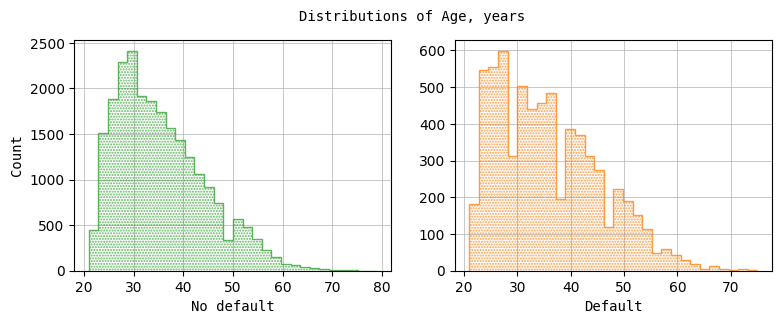

In [44]:
# Check distributions
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(age_no_default, bins=30, color = 'C2', alpha=0.75, histtype='step', hatch='.'*6)
plt.xlabel('No default', size=10, family='monospace')
plt.ylabel('Count', size=10, family='monospace')
plt.grid(lw=0.5)
plt.subplot(1, 2, 2)
plt.hist(age_default, bins=30, color = 'C1', alpha=0.75, histtype='step', hatch='.'*6)
plt.xlabel('Default', size=10, family='monospace')
plt.grid(lw=0.5)
plt.suptitle('Distributions of Age, years', size=10, family='monospace');

In [45]:
# Point estimate for difference of medians
print('No default group')
print(f'{"Mean:":<21} {age_no_default.mean():,.2f}')
print(f'{"":-<28}')
print('Default group')
print(f'{"Mean:":<21} {age_default.mean():,.2f}')
mean_delta = age_no_default.mean() - age_default.mean()
print(f'{"":-<28}')
print(f'{"Expected difference:":<21} 0.0')
print(f'{"Observed difference:":<20} {mean_delta:,.2f}')

No default group
Mean:                 35.42
----------------------------
Default group
Mean:                 35.73
----------------------------
Expected difference:  0.0
Observed difference: -0.31


In [46]:
# t-score and p-value
n_1 = age_no_default.shape[0]
n_2 = age_default.shape[0]
var_1 = age_no_default.var(ddof=1)
var_2 = age_default.var(ddof=1)
se = np.sqrt(var_1 / n_1 + var_2 / n_2)
t_score = (age_no_default.mean() - age_default.mean()) / se
vn_1 = var_1 / n_1
vn_2 = var_2 / n_2
df = (vn_1 + vn_2) ** 2 / (vn_1 ** 2 / (n_1 - 1) + vn_2 ** 2 / (n_2 - 1))
# Null distribution -- t-distribution
null_distr = t(df=df)
# Null rejection boundaries
critical_boundaries = null_distr.ppf([alpha / 2, 1 - alpha / 2])
# 95% confidence interval estimate for difference of means
ci = [mean_delta - critical_boundaries[1] * se, mean_delta + critical_boundaries[1] * se]
print(f'Two-sided alternative 95% confidence interval for difference of means is [{ci[0]:,.2f}; {ci[1]:,.2f}]')
p_value = 2 * null_distr.cdf(-np.abs(t_score))
print(f'{p_value = :.4f}')
print(f'Difference of {mean_delta:,.2f} in `no default` and `default` groups is statistically significant') \
if p_value < alpha else print(f'Difference of {mean_delta:,.2f} is not statistically significant')

Two-sided alternative 95% confidence interval for difference of means is [-0.57; -0.05]
p_value = 0.0204
Difference of -0.31 in `no default` and `default` groups is statistically significant


In [47]:
# Same result can be obtained with `scipy.stats.ttest_ind()` function
(ttest_ind(age_no_default.values, age_default.values, equal_var=False, alternative='two-sided'),
ttest_ind(age_no_default.values, age_default.values, equal_var=False, alternative='two-sided').confidence_interval(confidence_level=1-alpha))

(TtestResult(statistic=-2.3195212416592628, pvalue=0.020386490255874648, df=10172.553086166805),
 ConfidenceInterval(low=-0.5691586275501982, high=-0.04778640743817786))

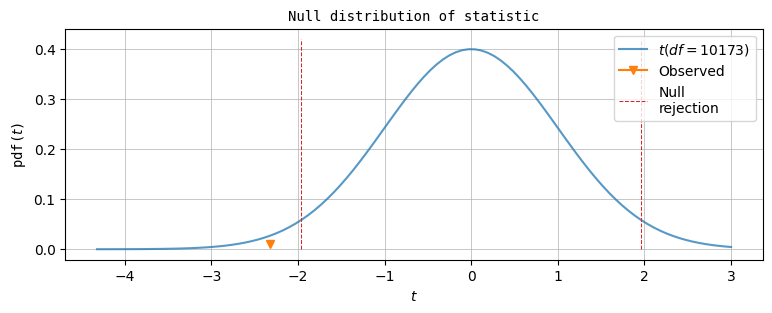

In [48]:
# Plot t-test results
plt.figure(figsize=(9, 3))
x = np.linspace(t_score - 2, 3, 100)
plt.plot(x, null_distr.pdf(x), color = 'C0', alpha=0.75, label=f'$t(df={df:.0f})$')
plt.plot(t_score, 0.01, color='C1', markersize=6, marker='v', label='Observed')
plt.vlines(critical_boundaries, 0, plt.ylim()[1], color='C3', ls='--', lw=0.75, label='Null\nrejection')
plt.xlabel('$t$', size=10, family='monospace')
plt.ylabel('pdf($t$)', size=10, family='monospace')
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.title(f'Null distribution of statistic', size=10, family='monospace');

Note: since the difference of means is really small, and age distributions look somewhat similar, let's also check their equality by Mann-Whitney test.

$H_0: F_{X_1}(x) =  F_{X_2}(x)$ (distributed identically)

$H_1: F_{X_1}(x) =  F_{X_2}(x + \Delta x)$ (distributed with some shift $\Delta x$)

Statistic: Mann-Whitney's $U$

Null distribution: no assumption; generated empirically by permutation test; for large samples it can be approximated by $\mathcal N (\mu = \frac{n_1 n_2}{2}, \sigma^2 = \frac{n_1 n_2 (n_1 + n_2 + 1)}{12})$

In [49]:
# p-value
result_mwu = mannwhitneyu(age_no_default, age_default, alternative='two-sided')
p_value = result_mwu.pvalue
print(f'{p_value = :.4f}')
print(f'Age distributions in `no default` and `default` groups are not identical') \
if p_value < alpha else print(f'Age distributions in `no default` and `default` groups are identical')

p_value = 0.3725
Age distributions in `no default` and `default` groups are identical


In [50]:
# Generate null distribution by using permutation test for Mann_Whitney statistic
result_permut = permutation_test((age_no_default, age_default), \
                           statistic=lambda x, y: mannwhitneyu(x, y).statistic, \
                            alternative='two-sided', \
                            permutation_type='independent', \
                            n_resamples=5000)
mwu_score = result_permut.statistic
p_value = result_permut.pvalue
print(f'{p_value = :.4f}')
print(f'Age distributions in `no default` and `default` groups are not identical') \
if p_value < alpha else print(f'Age distributions in `no default` and `default` groups are identical')

p_value = 0.3703
Age distributions in `no default` and `default` groups are identical


In [51]:
# Theoretical null distribution -- normal distribution
mu = n_1 * n_2 / 2
sigma = np.sqrt((n_1 * n_2 * (n_1 + n_2 + 1)) / 12)
null_distr_theory = norm(loc=mu, scale=sigma)
# Null distribution generated by permutation test
null_distr_permut = result_permut.null_distribution
# Null rejection boundaries
critical_boundaries = percentile_interval(null_distr_permut, alpha)

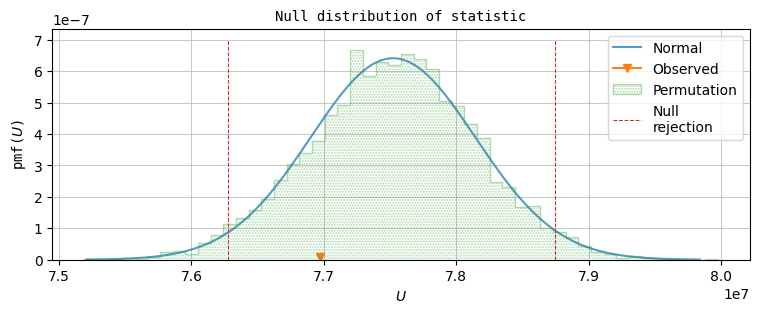

In [52]:
# Plot Mann-Whitney test results
plt.figure(figsize=(9, 3))
x = np.linspace(null_distr_theory.ppf(0.0001), null_distr_theory.ppf(0.9999), 1000)
plt.plot(x, null_distr_theory.pdf(x), color = 'C0', alpha=0.75, label='Normal')
plt.plot(mwu_score, 1e-8, color='C1', markersize=6, marker='v', label='Observed')
plt.hist(null_distr_permut, bins=50, density=True, color = 'C2', alpha=0.35, histtype='step', hatch='.'*6, label='Permutation')
plt.vlines(critical_boundaries, 0, plt.ylim()[1], color='C3', ls='--', lw=0.75, label='Null\nrejection')
plt.xlabel('$U$', size=10, family='monospace')
plt.ylabel('pmf($U$)', size=10, family='monospace')
plt.legend(loc='upper right')
plt.grid(lw=0.5)
plt.title(f'Null distribution of statistic', size=10, family='monospace');

Discussion

- Point estimate of difference between means in two groups is -0.31.
- Two-sided alternative 95% confidence interval of difference is [-0.57; -0.05].
- $P$-value for $t$-test is 0.0204 (null is rejected: means are not equal)
- $P$-value for Mann-whitney test is 0.3725 (null is not rejected: distributions are identical).
- We have shown that the difference of means of age in `no default` and `default` groups is statistically significant, as per $t$-test.
- It means that customers are _younger_ in `no default` group than in `default` group indeed.
- Though $t$-test result is statistically significant, the absolute difference of means is less than a year of age, which means that this difference is not practically valuable information. This is also confirmed by Mann-Whitney test, per which the difference in the distributions of age between groups is _not_ statistically significant.

---
##### <a id="discussion"></a>3. Discussion

We have shown that 4 of the 5 factors significantly differ between the `no default` and `default` groups:

- `LIMIT_BAL`: customers in `no default` group have _higher_ median credit limit than those in `default` group.

- `GENDER`: proportion of women in `no default` group is _higher_ than those in `default` group. Since proportions add up to 1.0, this result also applies to men: proportion of men in `no default` group is _lower_ than those in `default` group.

- `EDUCATION`: doctorate, masters, elementary education, other, and no data levels default _less_ than expected (good); bachelor, school graduate levels default _more_ than expected (bad). Default status is strongly dependent on almost all levels of education, as seen by standardized Pearson residuals.

- `MARITAL`: no answer and single statuses default _less_ than expected (good); married and no data statuses default _more_ than expected (bad). Default status is strongly dependent on single and married statuses, as seen by standardized Pearson residuals.

At the same time, `AGE` does not seem to differ between the groups.